# Régression supervisée

## Import des outils / jeu de données

In [69]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split

from src.data.load_data import get_df
from src.utils import init_notebook
from sklearn.linear_model import LogisticRegression

import xgboost as xgb

In [44]:
init_notebook()

In [45]:
df = get_df()

In [46]:
event_times = df["day_succ"]
event_observed = df["Status"]

On ne s'intéresse qu'aux variables suivantes

In [47]:
df = df[
    [
        "day_succ",
        "Status",
        "has_video",
        "facebook_connected",
        "goal",
        "facebook_friends",
    ]
]

# Régression logistique

Nous cherchons à prévoir si le projet sera financé dans les 60 jours impartis ou non.

In [48]:
X = df.drop(["day_succ", "Status"], axis=1)
y = event_observed

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [50]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

In [51]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.6371925946394031

Nous obtenons une accuracy de 62%, ce qui est relativement peu.

In [52]:
# Get coefficients
log_reg_coeff = pd.DataFrame(
    {"Variable": [col for col in X.columns], "Coefficient": log_reg.coef_[0].tolist()}
)
log_reg_coeff

,Variable,Coefficient
0,has_video,0.919525
1,facebook_connected,-0.077929
2,goal,-10.050154
3,facebook_friends,0.326993


## Régression linéaire

Nous cherchons à déterminer quelle est la durée de financement d'un projet, sachant qu'il a été financé.

In [53]:
# Redefine variables
X = df[event_observed == 1].drop(["Status", "day_succ"], axis=1)
y = df["day_succ"][event_observed == 1]

Text(0.5, 0, 'Nombre de jours avant le financement')

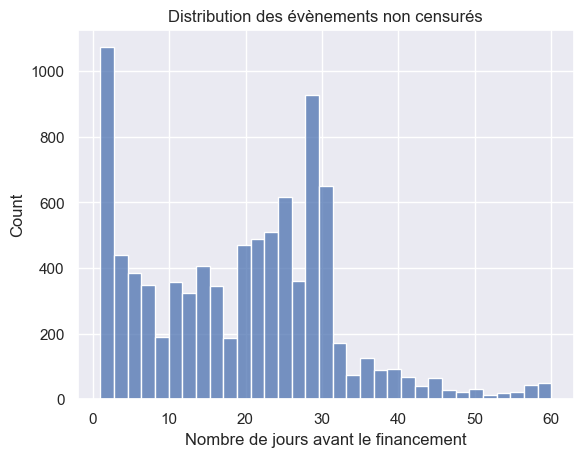

In [54]:
sns.histplot(y)
plt.title("Distribution des évènements non censurés")
plt.xlabel("Nombre de jours avant le financement")

### Modèle explicatif

In [55]:
# Add constant
X = sm.add_constant(X)

# Define and fit model
linear_explic = sm.OLS(y, X).fit()

# Predict
y_pred_explic = linear_explic.predict(X)

# Calculate residuals
residuals_explic = y_pred_explic - y

#### Diagnostic

In [56]:
linear_explic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               day_succ   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     36.39
Date:                Thu, 13 Mar 2025   Prob (F-statistic):           3.20e-30
Time:                        15:51:08   Log-Likelihood:                -35466.
No. Observations:                9028   AIC:                         7.094e+04
Df Residuals:                    9023   BIC:                         7.098e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 15.8305      0.438     36.182      0.000      14.973      16.688
has_video              3.2429      0.413      7.859      0.000       2.434       4.052
facebook_connected     1.2732      0.288      4.425      0.000       0.709       1.837
goal                  19.6252      3.608      5.440      0.000      12.553      26.697
facebook_friends       0.4938      0.139      3.552      0.000       0.221       0.766
==============================================================================
Omnibus:                      206.018   Durbin-Watson:                   1.476
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              219.795
Skew:                           0.379   Prob(JB):                     1.87e-48
Kurtosis:                       3.091   Cond. No.                         44.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* Un objectif financier (`goal`) ambitieux signifie plus de temps avant d'atteindre le financement. C'est la variable la plus influente.
* Avoir une **vidéo pour promouvoir le projet est très favorable**.
* Plus le compte facebook du projet a d'abonnés, plus la durée de financement est courte. 
* `facebook_connected` engendre un problème de multicolinéarité avec `facebook_friends` et n'est donc pas significative. On la retire de l'analyse.

In [57]:
# Drop variable
X = X.drop("facebook_connected", axis=1)

Text(0.5, 1.0, 'Distribution des résidus')

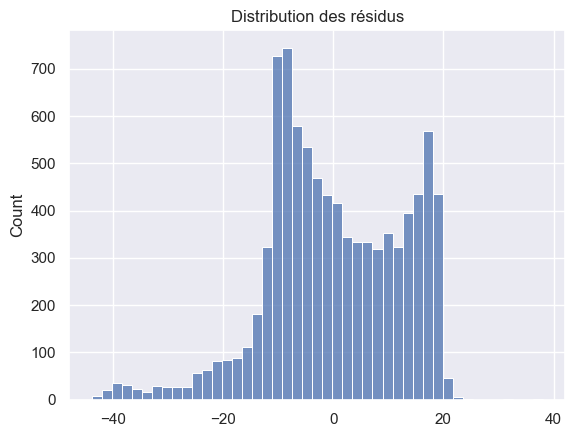

In [58]:
sns.histplot(residuals_explic)
plt.title("Distribution des résidus")

### Modèle prédictif

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [60]:
linear = LinearRegression(fit_intercept=False)
linear.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [61]:
# Get coefficients
coefficients_df = pd.DataFrame(
    {"Variable": [col for col in X.columns], "Coefficient": linear.coef_.tolist()}
)
coefficients_df

,Variable,Coefficient
0,const,16.363632
1,has_video,3.459410
2,goal,15.353753
3,facebook_friends,0.638663


In [62]:
# Evaluate model prediction capacity
y_pred = linear.predict(X_test)

linear_mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
linear_mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)

print(f"Mean squared error = {round(linear_mse)}")
print(f"Mean absolute error = {round(linear_mae, 2)}")

Mean squared error = 154
Mean absolute error = 10.28


En moyenne, le modèle de régression linéaire parvient à prévoir la durée nécessaire au financement à 12 jours près. 

## Forêt aléatoire

In [63]:
# Create and train a Random Forest Regressor
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [64]:
# Get feature importances
feature_importances = random_forest.feature_importances_

# Display feature importances
importances_df = pd.DataFrame(
    {"Variable": [col for col in X.columns], "Importance": feature_importances.tolist()}
)
importances_df

,Variable,Importance
0,const,0.000000
1,has_video,0.034423
2,goal,0.365493
3,facebook_friends,0.600083


In [65]:
# Evaluate model prediction capacity
y_pred_rf = random_forest.predict(X_test)

# Calculate Mean Squared Error and Mean Absolute Error
rf_mse = mean_squared_error(y_true=y_test, y_pred=y_pred_rf)
rf_mae = mean_absolute_error(y_true=y_test, y_pred=y_pred_rf)

print(f"Random Forest Mean Squared Error = {round(rf_mse)}")
print(f"Random Forest Mean Absolute Error = {round(rf_mae, 2)}")

Random Forest Mean Squared Error = 165
Random Forest Mean Absolute Error = 10.32


En moyenne, le modèle de forêt aléatoire parvient à prévoir la durée nécessaire au financement à 11 jours près.

## XGBoost

In [70]:
xgb = xgb.XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [71]:
# Evaluate model prediction capacity
y_pred_xgb = xgb.predict(X_test)

# Calculate Mean Squared Error and Mean Absolute Error
xgb_mse = mean_squared_error(y_true=y_test, y_pred=y_pred_xgb)
xgb_mae = mean_absolute_error(y_true=y_test, y_pred=y_pred_xgb)

print(f"XGBoost Mean Squared Error = {round(xgb_mse)}")
print(f"XGBoost Mean Absolute Error = {round(xgb_mae, 2)}")

XGBoost Mean Squared Error = 159
XGBoost Mean Absolute Error = 10.11


En moyenne, le XGBoost parvient à prévoir la durée nécessaire au financement à 10 jours près.

# Réseau de neurones

In [66]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [67]:
# Create and train a Multi-layer Perceptron Regressor
mlp_regressor = MLPRegressor(
    hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42
)
mlp_regressor.fit(X_train, y_train)

# Evaluate model prediction capacity
y_pred_mlp = mlp_regressor.predict(X_test)

# Calculate Mean Squared Error and Mean Absolute Error
mlp_mse = mean_squared_error(y_true=y_test, y_pred=y_pred_mlp)
mlp_mae = mean_absolute_error(y_true=y_test, y_pred=y_pred_mlp)

print(f"MLP Regressor Mean Squared Error = {round(mlp_mse)}")
print(f"MLP Regressor Mean Absolute Error = {round(mlp_mae, 2)}")

MLP Regressor Mean Squared Error = 154
MLP Regressor Mean Absolute Error = 10.25


En moyenne, le réseau de neurones parvient à prévoir la durée nécessaire au financement à 12 jours près.  

---

# Bilan

| Régression logistique | Accuracy     |
|:----------------------|-------------:|
| Le projet sera-t-il financé ?   |     62% |

**Tableau.** Modèle de prévision et MAE correspondante obtenue sur l'ensemble de test

| Modèle               | MAE          |
|:----------------------|-------------:|
| Régression Linéaire   |     12 jours |
|**Forêt Aléatoire**       |     **11 jours** |
| Réseau de Neurones    |     12 jours |

**On conservera donc le modèle de forêt aléatoire pour la prédiction.**